# CAPM

* Goal: a brief walkthrough of CAPM and APT using real stock data
* What you will learn:
    - Data wrangling
    - CAPM models
    - ggplot 

## load packages

In [1]:
require('dplyr')
require('ggplot2')
require('tidyr')
require('quadprog')

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: tidyr
Loading required package: quadprog


## set figure size

In [2]:
options(repr.plot.width=7, repr.plot.height=5)

## Get data online
Data can be obtained from here: https://stooq.com/db/h/

## Read data in raw format

In [3]:
options(warn = -1)
path =  './data'
# read the stock open into a table
files = list.files(path = path, pattern = '*.txt')
files_with_path = lapply(files, function(x) paste(path, x, sep = '/'))
print(read.csv(files_with_path[[1]]) %>% head)
stock_prices = read.csv(files_with_path[[1]]) %>% select('Date')
for (i in 1:length(files)){
    ticker = strsplit(files[[i]], split = '\\.')[[1]][1]
    a = tryCatch({read.csv(files_with_path[[i]]) %>% select('Date', 'Open')}, error = function(e) {return(NULL)})
    if (is.null(a)) {
        next
    }
    names(a)[2] = ticker
    stock_prices = stock_prices %>% left_join(a, by = c('Date' = 'Date')) 
}
print(dim(stock_prices))

        Date   Open   High    Low  Close   Volume OpenInt
1 1999-11-18 30.645 33.679 26.942 29.636 66425227       0
2 1999-11-19 28.922 28.962 26.812 27.196 16178900       0
3 1999-11-22 27.824 29.636 26.984 29.636  6985802       0
4 1999-11-23 28.624 29.381 26.942 26.942  6346195       0
5 1999-11-24 27.023 28.246 26.942 27.655  5143586       0
6 1999-11-26 27.533 27.950 27.448 27.745  1836720       0
[1] 4565 1996


## take a look of missing value rates

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


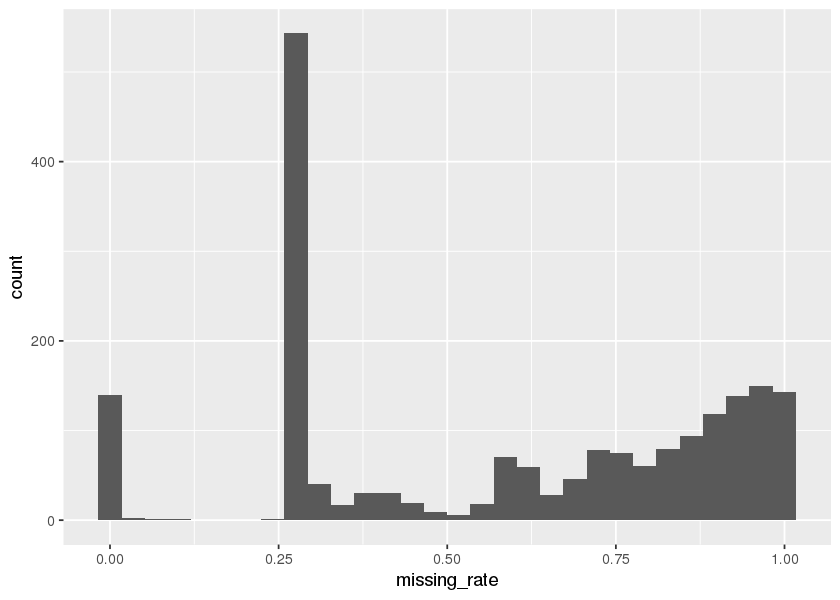

In [4]:
missing_info = stock_prices %>% gather_(key_col = 'Stock', value_col = 'Open', gather_cols = names(stock_prices)[-1]) %>%
group_by(Stock) %>% summarise(missing_rate = mean(is.na(Open))) 
missing_info %>% ggplot() + 
geom_histogram(aes(x = missing_rate), title = 'missing rate of stocks')

## dealing with missing values

In [5]:
missing_rate = colMeans(is.na(stock_prices))
partial_stock_prices = stock_prices %>% select(which(missing_rate < .3))                            
complete_stock_prices = partial_stock_prices %>% filter(complete.cases(partial_stock_prices))
print(dim(complete_stock_prices))
head(complete_stock_prices)

[1] 2686  703


Date,a,aa,aan,aap,aav,ab,abb,abc,abg,⋯,kgc,kim,kmb,kmm,kmt,kmx,knd,knl,ko,kof
2005-04-27,14.333,60.258,11.949,34.545,15.50,27.045,4.5399,13.553,14.16,⋯,5.1399,20.175,48.848,6.2663,19.714,14.28,20.627,14.531,17.352,20.366
2005-04-28,14.211,59.610,13.850,34.881,15.12,27.134,4.5873,13.666,14.00,⋯,5.0045,20.477,49.124,6.2782,19.583,14.12,22.967,14.237,17.247,20.307
2005-05-02,13.978,60.842,14.380,35.079,14.60,27.045,4.6586,13.842,13.65,⋯,5.1788,20.588,49.409,6.2482,19.826,13.60,22.790,13.613,17.595,19.723
2005-05-04,14.279,60.927,14.645,35.019,14.69,26.162,4.6745,13.944,13.92,⋯,5.3433,20.739,49.416,6.2725,19.669,14.03,23.538,13.737,17.791,19.552
2005-05-09,14.414,61.423,15.009,36.089,14.81,27.045,4.7142,14.247,14.09,⋯,5.4206,21.050,48.729,6.2051,19.906,14.35,24.216,13.569,17.881,19.723
2005-05-12,14.595,59.317,14.516,35.531,14.54,27.045,4.7776,14.392,13.95,⋯,5.1302,21.318,49.440,6.1256,19.365,13.88,24.691,13.862,18.105,19.595


## calculate the return

In [9]:
num_days = nrow(complete_stock_prices)
num_cols = ncol(complete_stock_prices)
stock_return = (complete_stock_prices[-1,2:num_cols] - complete_stock_prices[-num_days,2:num_cols])/complete_stock_prices[-num_days,2:num_cols]
rownames(stock_return) = complete_stock_prices$Date[-1]
num_stocks = num_cols - 1
head(stock_return)

,a,aa,aan,aap,aav,ab,abb,abc,abg,abm,⋯,kgc,kim,kmb,kmm,kmt,kmx,knd,knl,ko,kof
2005-04-28,-0.008511826,-0.010753759,0.15909281,0.009726444,-0.024516129,0.003290812,0.010440759,0.008337637,-0.011299435,-0.009334519,⋯,-0.02634292,0.014969021,0.0056501802,0.001899047,-0.006645024,-0.01120448,0.11344354,-0.020232606,-0.006051176,-0.002896985
2005-05-02,-0.016395750,0.020667673,0.03826715,0.005676443,-0.034391534,-0.003280018,0.015542912,0.012878677,-0.025000000,-0.005448369,⋯,0.03482865,0.005420716,0.0058016448,-0.004778440,0.012408722,-0.03682720,-0.00770671,-0.043829458,0.020177422,-0.028758556
2005-05-04,0.021533839,0.001397061,0.01842837,-0.001710425,0.006164384,-0.032649288,0.003413043,0.007368877,0.019780220,0.009925238,⋯,0.03176412,0.007334370,0.0001416746,0.003889120,-0.007918894,0.03161765,0.03282141,0.009108940,0.011139528,-0.008670081
2005-05-09,0.009454444,0.008140890,0.02485490,0.030554842,0.008168822,0.033751242,0.008492887,0.021729776,0.012212644,0.017421825,⋯,0.01446672,0.014995901,-0.0139023798,-0.010745317,0.012049418,0.02280827,0.02880449,-0.012229744,0.005058738,0.008745908
2005-05-12,0.012557236,-0.034286831,-0.03284696,-0.015461775,-0.018230925,0.000000000,0.013448729,0.010177581,-0.009936125,0.003261620,⋯,-0.05357341,0.012731591,0.0145909007,-0.012812042,-0.027177735,-0.03275261,0.01961513,0.021593338,0.012527264,-0.006489885
2005-05-16,0.008359027,-0.067282567,-0.00137779,-0.011905097,-0.085969739,-0.005324459,-0.009942230,0.005558644,-0.010752688,-0.020318850,⋯,-0.07732642,-0.016746411,-0.0063915858,0.002987462,-0.035476375,-0.02809798,0.01931878,-0.005843313,-0.012096106,-0.007501914


## save the workspace

In [10]:
save.image('workspace.RData')

In [ ]:
load('workspace.RData')

## CAPM model
- Suppose we have $p$ stocks at $n$ days, and their expected return $c\in \mathbb{R}^{p\times 1}$, and their covariance matrix is $X \in \mathbb{R}^{p\times p}$
- For a weighted portfolio with weights $w\in \mathbb{R}^{p\times 1}$, the expected return is $c^Tw$ and the variance is $w^TXw$. 
- We want to minimize the variance as well as maximize the expected return, which can be achieved by

$$
\textrm{minimize  } -c^Tw + \frac{\gamma}{2}w^TXw,  \textrm{subject to  } \mathbf{1}^Tw = 1, w \geq 0,
$$
where $\gamma > 0$ is a positive real number.

- This is a convex quadratic programming problem.
- With risk-free bond return, we get the optimal $w^*$

In [44]:
gammas = exp(-10:10)
weights = list()
for (i in 1:length(gammas)){
    gamma = gammas[i]
    c = as.vector(colMeans(stock_return))
    X = cov(stock_return) 
    n = 10
    Amat = cbind(rep(1, n), diag(1, n))
    bvec = as.vector(c(1, rep(0, n)))
    out = solve.QP(dvec = c[1:n]/gamma, Dmat = X[1:n,1:n], Amat = Amat, factorized = FALSE, bvec = bvec, meq = 1)
    weights[[i]] = out$solution
}


In [45]:
lapply(weights, function(x) c(sum(c * x), 

[[1]]
 [1]  8.453329e-13 -1.186876e-12  0.000000e+00  3.287086e-12  3.748728e-12
 [6] -1.720912e-14  0.000000e+00 -3.792218e-13  1.000000e+00  3.680511e-12

[[2]]
 [1]  3.108987e-13 -4.365609e-13  0.000000e+00  1.209158e-12  1.379135e-12
 [6] -6.399204e-15  0.000000e+00 -1.394738e-13  1.000000e+00  1.353642e-12

[[3]]
 [1]  1.142913e-13 -1.605355e-13  0.000000e+00  4.447313e-13  5.074102e-13
 [6] -2.422458e-15  0.000000e+00 -5.127547e-14  1.000000e+00  4.976349e-13

[[4]]
 [1]  4.196355e-14 -5.899149e-14  0.000000e+00  1.635143e-13  1.867206e-13
 [6] -9.594946e-16  0.000000e+00 -4.725082e-14  1.000000e+00  1.827274e-13

[[5]]
 [1]  1.535564e-14 -2.163552e-14  0.000000e+00  6.006039e-14  6.874555e-14
 [6] -4.213005e-16  0.000000e+00 -6.892765e-15  1.000000e+00  6.687946e-14

[[6]]
 [1]  5.567135e-15 -3.631474e-14  0.000000e+00  7.790956e-15  2.534494e-14
 [6] -1.443416e-14  0.000000e+00 -2.501627e-15  1.000000e+00  2.426137e-14

[[7]]
 [1]  1.966146e-15 -2.837448e-15  0.000000e+00  8.000842e-15  1.648417e-14
 [6] -1.504733e-16  1.776357e-15 -8.862183e-16  1.000000e+00  8.583055e-15

[[8]]
 [1]  6.414161e-16 -9.776038e-16  0.000000e+00  2.850174e-15  3.505111e-15
 [6] -1.236782e-16  0.000000e+00 -2.919425e-16  1.000000e+00  2.815324e-15

[[9]]
 [1]  1.540753e-16 -2.934054e-16  2.220446e-16  9.553486e-16  1.344322e-15
 [6] -1.138208e-16  0.000000e+00 -7.332060e-17  1.000000e+00  6.934939e-16

[[10]]
 [1] -1.272196e-17 -4.431940e-17  0.000000e+00  2.647559e-16  5.359631e-16
 [6] -9.876705e-17  6.169730e-02  6.089520e-02  8.774075e-01 -2.879305e-17

[[11]]
 [1] -2.286637e-18  1.686560e-17  0.000000e+00  6.256690e-17  1.712979e-16
 [6] -3.055445e-17  2.043036e-01  4.549939e-01  3.407025e-01 -1.693720e-17

[[12]]
 [1]  3.584564e-02  7.839278e-18  6.153046e-02  2.246276e-03  2.976234e-17
 [6] -2.465517e-17  2.184188e-01  5.531707e-01  1.287881e-01  0.000000e+00

[[13]]
 [1] 9.968045e-02 1.598800e-17 7.914448e-02 1.234743e-01 1.387779e-17
 [6] 4.427702e-17 1.531987e-01 4.903608e-01 2.459536e-02 2.954584e-02

[[14]]
 [1] 1.045858e-01 5.030015e-18 7.379962e-02 1.528604e-01 0.000000e+00
 [6] 1.054903e-17 1.147149e-01 4.524451e-01 3.452615e-18 1.015942e-01

[[15]]
 [1]  9.924514e-02  4.047688e-18  7.011718e-02  1.611720e-01  1.492382e-02
 [6]  0.000000e+00  9.271342e-02  4.365872e-01 -1.480487e-18  1.252412e-01

[[16]]
 [1]  9.572470e-02  4.320921e-18  6.872881e-02  1.639954e-01  2.534950e-02
 [6]  0.000000e+00  8.260175e-02  4.301102e-01 -6.811472e-19  1.334897e-01

[[17]]
 [1]  9.442960e-02  4.421438e-18  6.821805e-02  1.650340e-01  2.918490e-02
 [6]  0.000000e+00  7.888188e-02  4.277274e-01 -3.870863e-19  1.365242e-01

[[18]]
 [1]  9.395316e-02  4.458416e-18  6.803016e-02  1.654161e-01  3.059586e-02
 [6]  0.000000e+00  7.751341e-02  4.268508e-01 -2.789074e-19  1.376405e-01

[[19]]
 [1]  9.377789e-02  4.472020e-18  6.796103e-02  1.655567e-01  3.111492e-02
 [6]  0.000000e+00  7.700998e-02  4.265283e-01 -2.391106e-19  1.380512e-01

[[20]]
 [1]  9.371341e-02  4.477024e-18  6.793560e-02  1.656084e-01  3.130588e-02
 [6]  0.000000e+00  7.682478e-02  4.264097e-01 -2.244701e-19  1.382022e-01

[[21]]
 [1]  9.368969e-02  4.478865e-18  6.792625e-02  1.656274e-01  3.137612e-02
 [6]  0.000000e+00  7.675665e-02  4.263661e-01 -2.190842e-19  1.382578e-01